En esta ocasión nuestro objetivo es generar un mapa de densidad de 
ocurrencias usando los datos del [SNIB] pare esto otra vez usaremos nuestros
datos de ejemplares de 
[mamíferos](http://www.snib.mx/ejemplares/mamiferos.201807.csv.zip) descargados 
desde el [Geoportal]. 

Primero generaremos un _raster_ sobre México que nos servirá como base para 
hacer el análisis. Para esto tenemos que obtener los datos 
geográficos necesarios para hacer dicho _raster_.  Un _raster_ es 
una malla sobre una región de la tierra donde cada cuadrito, _pixel_, de la malla se le 
asigna un valor. La resolución del _raster_ es el _área_ de cada cuadro, en este
ejemplo trabajaremos con un raster de resolución de 10Km x 10Km.


[SNIB]: http://www.snib.mx/
[Geoportal]: http://geoportal.conabio.gob.mx/

In [1]:
library(magrittr)
library(dplyr)
library(readr)
library(sf)
library(ggplot2)
library(maps)
library(raster)
library(rasterVis)
library(RColorBrewer)

mx_border <- st_as_sf(maps::map('world', 
                                regions = "Mexico", 
                                plot = FALSE, 
                                fill = TRUE))

mx_border %>% st_crs()


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Linking to GEOS 3.8.0, GDAL 3.0.2, PROJ 6.2.1

Loading required package: sp


Attaching package: ‘raster’


The following object is masked from ‘package:dplyr’:

    select


The following object is masked from ‘package:magrittr’:

    extract


Loading required package: lattice

Loading required package: latticeExtra


Attaching package: ‘latticeExtra’


The following object is masked from ‘package:ggplot2’:

    layer




Coordinate Reference System:
  EPSG: 4326 
  proj4string: "+proj=longlat +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +no_defs"

La variable `mx_border` es un _simplefeature_ el cual no tiene proyección 
asociada, en este caso está en coordenadas geográficas, por lo que lo 
proyectaremos usando una proyección confrome cónica de Lambert pero definida
para el caso de México, la [EPSG:6372](https://epsg.io/6372).

In [2]:
mx_border <- mx_border %>% 
  st_transform(crs = 6372)
mx_border %>%
  st_crs()

mx_bbox <- mx_border %>%
  st_bbox()

Coordinate Reference System:
  EPSG: 6372 
  proj4string: "+proj=lcc +lat_0=12 +lon_0=-102 +lat_1=17.5 +lat_2=29.5 +x_0=2500000 +y_0=0 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs"

En particular notemos que en la nueva proyección se tiene que la unidad de 
proyección es en metros.

In [3]:
mx_proj <- mx_border %>% 
    st_crs() %$% 
    proj4string
ANALYSIS_RESOLUTION <- 10000 # 10,000m = 10Km 

ncol <- ceiling((mx_bbox[["xmax"]] - mx_bbox[["xmin"]])/ANALYSIS_RESOLUTION)
nrow <- ceiling((mx_bbox[["ymax"]] - mx_bbox[["ymin"]])/ANALYSIS_RESOLUTION)

mx_raster_bbox <- raster(
    ncol = ncol, 
    nrow = nrow, 
    xmn = mx_bbox[["xmin"]], 
    xmx = mx_bbox[["xmax"]], 
    ymn = mx_bbox[["ymin"]], 
    ymx = mx_bbox[["ymax"]]
) 
projection(mx_raster_bbox) <- mx_proj

La variable `mx_raster_bbox` es un raster, sin valores para cada _pixel_ pero
con la resolución que queremos para nuestro análisis. Ahora lo que haremos es 
usar un una función la cual asigna un valor si la geometría intersecta un 
_pixel_, en este caso los registros del [SNIB], esta función es 
[`raster::rasterize`](https://www.rdocumentation.org/packages/raster/versions/2.6-7/topics/rasterize),
además si un o más geometrias tocan un pixel usa una función para agrupar los 
valores, en este caso usaremos `count`

In [4]:
MAMMALS_URI <- 'http://www.snib.mx/ejemplares/mamiferos.201807.csv.zip'
mammals_zip <- tempfile(fileext = '.zip')
curl::curl_download(MAMMALS_URI, mammals_zip)

mammals_data <- mammals_zip %>% 
    unzip(files = c('mamiferos.csv'), exdir = tempdir()) %>% 
    read_csv(progress = FALSE) %>%
    dplyr::select(idejemplar, longitud, latitud) %>%
    st_as_sf(coords = c("longitud", "latitud"),
           crs = 4326)
mammals_data %<>% st_transform(crs = 6372)

ptm <- proc.time()
mx_raster <- rasterize(as(mammals_data, "Spatial"), 
                       mx_raster_bbox, 
                       field = 1, 
                       fun = "count")
proc.time() - ptm

Parsed with column specification:
cols(
  .default = col_character(),
  longitud = col_double(),
  latitud = col_double(),
  categoriaresidenciaaves = col_logical(),
  formadecrecimiento = col_logical(),
  taxonextinto = col_logical(),
  ultimafechaactualizacion = col_date(format = ""),
  categoriainfraespecie2 = col_logical(),
  categoriainfraespecie2valida = col_logical(),
  mt24claveestadomapa = col_logical(),
  mt24nombreestadomapa = col_logical(),
  mt24clavemunicipiomapa = col_logical(),
  mt24nombremunicipiomapa = col_logical(),
  altitudmapa = col_double(),
  fechadeterminacion = col_logical(),
  diadeterminacion = col_double(),
  mesdeterminacion = col_double(),
  aniodeterminacion = col_double(),
  diacolecta = col_double(),
  mescolecta = col_double(),
  aniocolecta = col_double()
  # ... with 2 more columns
)

See spec(...) for full column specifications.

Warning message:
“425069 parsing failures.
 row                 col           expected actual                          

   user  system elapsed 
  7.029   0.000   7.041 

Por útimo graficaremos el resultado.

Warning message in brewer.pal(41, "Spectral"):
“n too large, allowed maximum for palette Spectral is 11
Returning the palette you asked for with that many colors
”


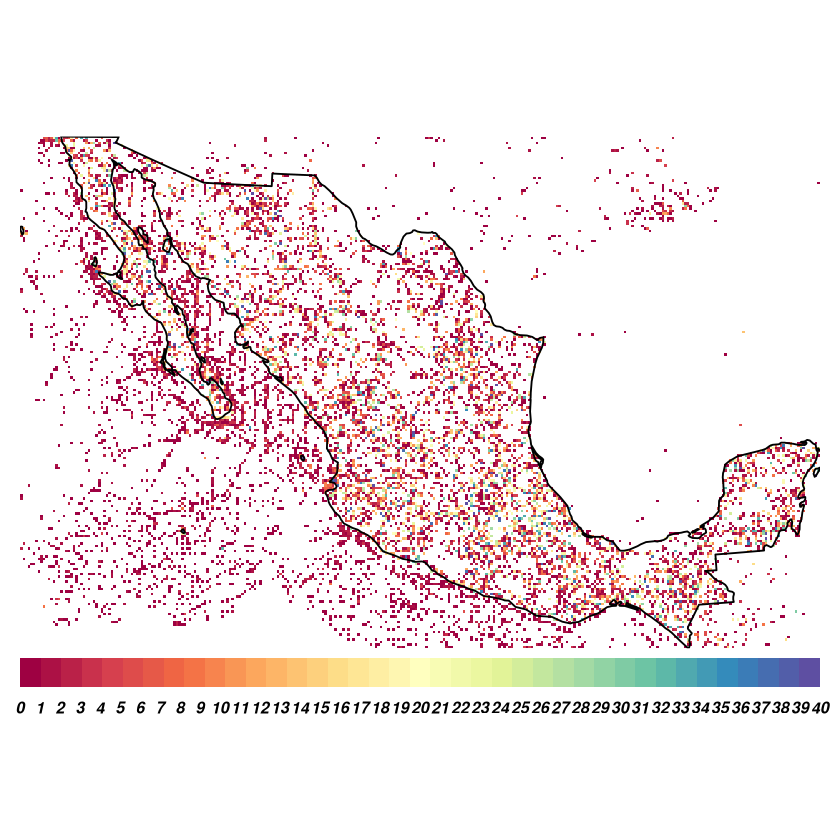

In [5]:
colr <- colorRampPalette(brewer.pal(41, 'Spectral'))

levelplot(mx_raster, 
          margin = FALSE,                       
          colorkey = list(
            space = 'bottom',                   
            labels = list(at = 0:40, font = 4)  
          ),    
          par.settings=list(
            axis.line=list(col='transparent') 
          ),
          scales=list(draw=FALSE),            
          col.regions=colr,                   
          at=seq(0, 40, len=40)) +           
    layer(sp.polygons(as(mx_border, "Spatial"), lwd = 1.5))    

In [6]:
sessionInfo()

R version 3.6.2 (2019-12-12)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Arch Linux

Matrix products: default
BLAS:   /usr/lib/libopenblasp-r0.3.7.so
LAPACK: /usr/lib/liblapack.so.3.9.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] RColorBrewer_1.1-2  rasterVis_0.47      latticeExtra_0.6-29
 [4] lattice_0.20-38     raster_3.0-7        sp_1.3-1           
 [7] maps_3.3.0          ggplot2_3.2.1       sf_0.8-0           
[10] readr_1.3.1         dplyr_0.8.3         magrittr_1.5       

loaded via a namespace (and not attached):
 [1] pbdZMQ_